In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
import matplotlib

In [2]:
import vice

/astro/dboyea/.local/lib/python3.11/site-packages/vice-1.4.0.dev0-py3.11-linux-x86_64.egg/vice/__init__.py:141: UserWarning: Using un-released version of VICE
  warnings.warn("Using un-released version of VICE", UserWarning)


In [3]:
import numpy as np

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import surp

import surp.gce_math as gcem
import arya

In [5]:
import sys
sys.path.append("..")

In [6]:
from mc_plot_utils import MCMCResult
import mc_plot_utils

In [7]:
from scipy.stats import binned_statistic

In [8]:
def load_model(filename, dirname="mcmc_models_2d"):
    modeldir = f"../../models/{dirname}/{filename}/"
    model = mc_plot_utils.MCMCResult.from_file(modeldir)
    binned_model = pd.read_csv(modeldir + "/2d_binned.csv")

    return binned_model, model.samples, model.labels

In [9]:
def plot_all(filename):
    model, samples, labels = load_model(filename)
    plot_mean_ahfe(model, samples, labels)
    plot_mean_ahfe(model, samples, labels, mode="residual")
    plot_mean_ahfe(model, samples, labels, mode="zscore")
    

In [10]:
def plot_mean_ahfe(afeh, samples, labels, mode='mean', **kwargs):
    fig, ax = plt.subplots()
    ax.set_xlabel("[Mg/H]")
    ax.set_ylabel("[Mg/Fe]")

    p, color_values = plot_mean_ahfe_(ax, afeh, samples, labels, mode=mode, **kwargs)

    if mode == 'residual':
        color_label = "Delta [C/Mg]"
    elif mode == 'zscore':
        color_label = "z score"
    else:
        color_label = "[C/Mg]"

    cbar = plt.colorbar(p, ax=ax)
    cbar.set_label(color_label)

    return fig

In [11]:
def to_brak(c_mg):
    return gcem.abund_ratio_to_brak(c_mg, "c", "mg")

In [24]:
def plot_mean_ahfe_(ax, afeh, samples, labels, thin=10, color='black', alpha=None,
                    colorrange=None, mode='mean', s_int = 0.05):
    # Compute the mean parameter values
    alpha_mean = np.mean(samples.loc[:, labels], axis=0)

    x, y = afeh['_x'], afeh['_y']
    if mode == "mean":
        print(alpha_mean)
    # Linear combination model
    y_model = sum(alpha_mean[i] * afeh[label] for i, label in enumerate(labels))

    # Determine color range
    if colorrange is None:
        cmin = min(np.min(y_model), np.min(afeh['obs']))
        cmax = max(np.max(y_model), np.max(afeh['obs']))
        colorrange = (to_brak(cmin), to_brak(cmax))

    # Scatter plot based on mode
    if mode == 'residual':
        res = to_brak(afeh['obs']) - to_brak(y_model)
        resmax = np.maximum(0.1, np.max(np.abs(res)))
        if resmax > 0.1:
            print("warning: residual > 0.1")
        p = ax.scatter(afeh['_x'], afeh['_y'], s=100, c=res, cmap='RdBu',
                       vmin=-resmax, vmax=resmax)

        return p, res

    elif mode == 'zscore':
        sy = afeh['obs_sem']
        sy_model = sum(alpha_mean[i] * afeh[f"{label}_sem"]
                       for i, label in enumerate(labels))
        sy_total = np.sqrt(sy**2 + sy_model**2) + s_int
        res = (afeh['obs'] - y_model) / sy_total
        resmax = np.max(np.abs(res))
        p = ax.scatter(afeh['_x'], afeh['_y'], s=100, c=res, cmap='RdBu',
                       vmin=-resmax, vmax=resmax)


        print("chi2 reduced = ", np.mean(res**2))
        return p, res

    elif mode == 'mean':
        c = to_brak(afeh['obs'])
        ax.scatter(x, y, s=100, c=c, vmin=colorrange[0], vmax=colorrange[1])
        ax.scatter(x, y, s=50, c='white')
        c = to_brak(y_model)
        p = ax.scatter(x, y, s=30, c=c, 
                       vmin=colorrange[0], vmax=colorrange[1])

        return p, y_model

    else:
        raise ValueError("Invalid mode. Use 'mean', 'residual', or 'zscore'.")

In [14]:
model, samples, labels = load_model("fiducial")

length of samples =  1000
{'alpha': {'name': 'perturbations/fruity', 'prior': 'Normal', 'prior_args': [1.0, 1.0]}, 'y0_cc': {'name': 'perturbations/constant', 'prior': 'Normal', 'prior_args': [2.0, 1.0]}, 'zeta_cc': {'name': 'perturbations/linear', 'prior': 'Normal', 'prior_args': [0.0, 2.0], 'y0': 0.001}}


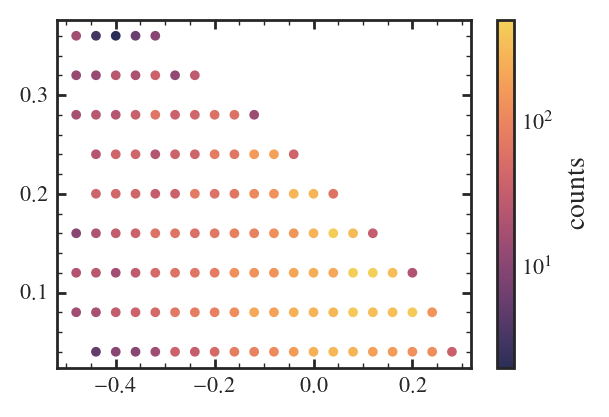

In [15]:
plt.scatter(model._x, model._y, c=model._counts, norm=matplotlib.colors.LogNorm())
plt.colorbar(label = "counts")

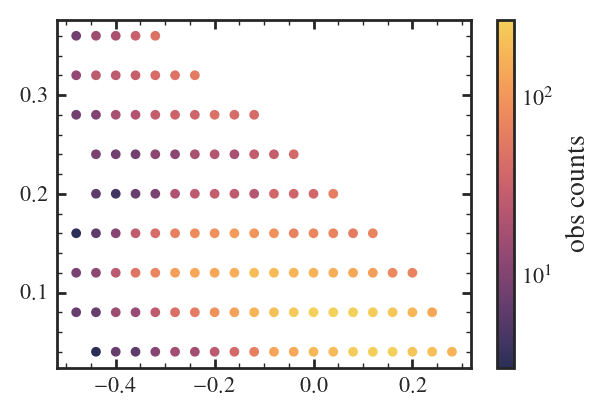

In [16]:
plt.scatter(model._x, model._y, c=model.obs_counts, norm=matplotlib.colors.LogNorm())
plt.colorbar(label = "obs counts")

In [17]:
surp.set_yields()

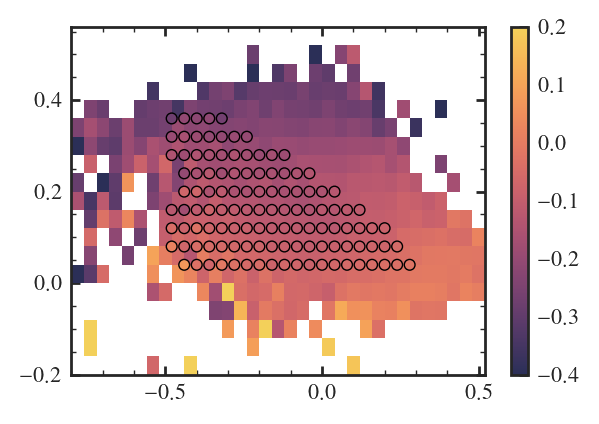

In [18]:
from scipy.stats import binned_statistic_2d
w = 0.04
bins=(np.arange(-0.8, 0.55, w), np.arange(-0.2, 0.6, w))

stat, xedges, yedges, binnumber = binned_statistic_2d(
    surp.subgiants.MG_H, surp.subgiants.MG_FE, surp.subgiants.C_MG, statistic='mean', bins=bins
)

fig, ax = plt.subplots()
pcm = ax.pcolormesh(bins[0], bins[1], stat.T, shading='auto', vmin=-0.4, vmax=0.2)


plt.scatter(model._x, model._y, c=to_brak(model.obs) , vmin=-0.4, vmax=0.2, ec="black", lw=0.5, s=15)

plt.colorbar(pcm)



length of samples =  48000
{'alpha': {'name': 'perturbations/fruity', 'prior': 'Normal', 'prior_args': [1.0, 1.0]}, 'y0_cc': {'name': 'perturbations/constant', 'prior': 'Normal', 'prior_args': [2.0, 1.0]}, 'zeta_cc': {'name': 'perturbations/linear', 'prior': 'Normal', 'prior_args': [0.0, 2.0], 'y0': 0.001}}
alpha      2.505518
y0_cc      0.986837
zeta_cc    0.895014
dtype: float64


/tmp/ipykernel_916725/1864777637.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_model = sum(alpha_mean[i] * afeh[label] for i, label in enumerate(labels))
/tmp/ipykernel_916725/1864777637.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_model = sum(alpha_mean[i] * afeh[label] for i, label in enumerate(labels))
/tmp/ipykernel_916725/1864777637.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_model = sum(alpha_mean

KeyError: 'obs_sem'

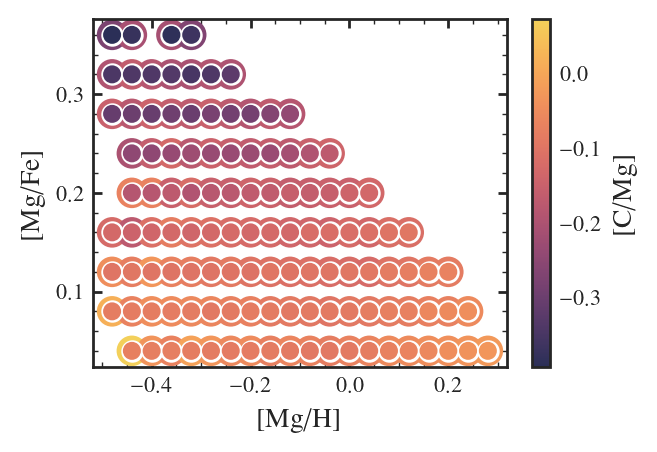

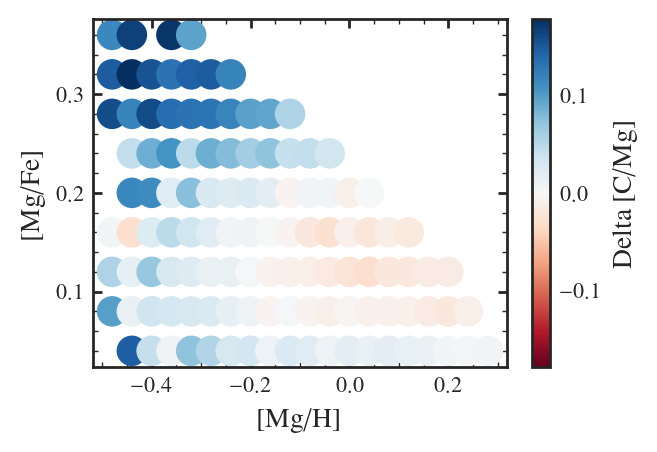

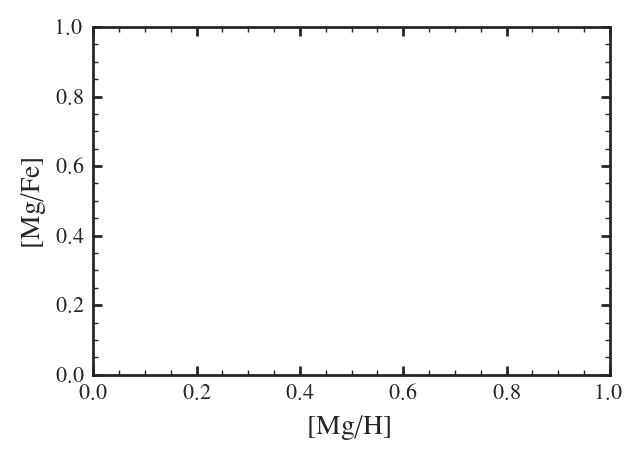

In [25]:
plot_all("../mcmc_models/fiducial")

length of samples =  48000
{'alpha': {'name': 'perturbations/fruity', 'prior': 'Normal', 'prior_args': [1.0, 1.0]}, 'y0_cc': {'name': 'perturbations/constant', 'prior': 'Normal', 'prior_args': [2.0, 1.0]}, 'zeta_cc': {'name': 'perturbations/linear', 'prior': 'Normal', 'prior_args': [0.0, 2.0], 'y0': 0.001}}
alpha      1.556503
y0_cc      1.742727
zeta_cc    0.428837
dtype: float64
chi2 reduced =  2.938543803342353


/tmp/ipykernel_916725/1864777637.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_model = sum(alpha_mean[i] * afeh[label] for i, label in enumerate(labels))
/tmp/ipykernel_916725/1864777637.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_model = sum(alpha_mean[i] * afeh[label] for i, label in enumerate(labels))
/tmp/ipykernel_916725/1864777637.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_model = sum(alpha_mean

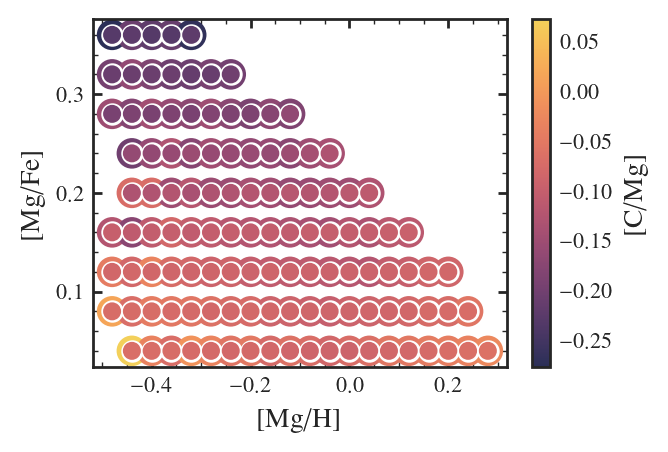

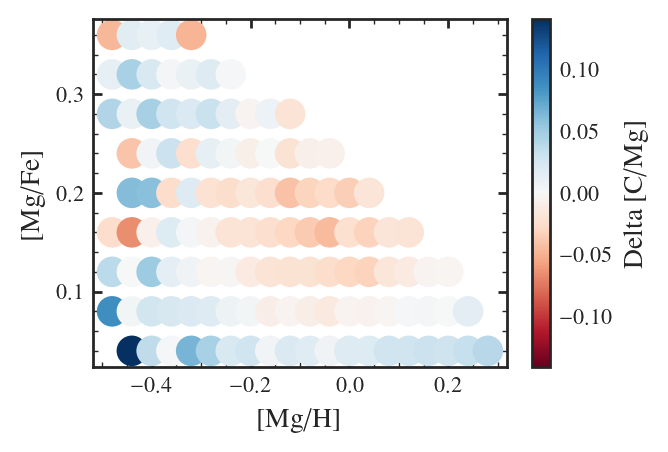

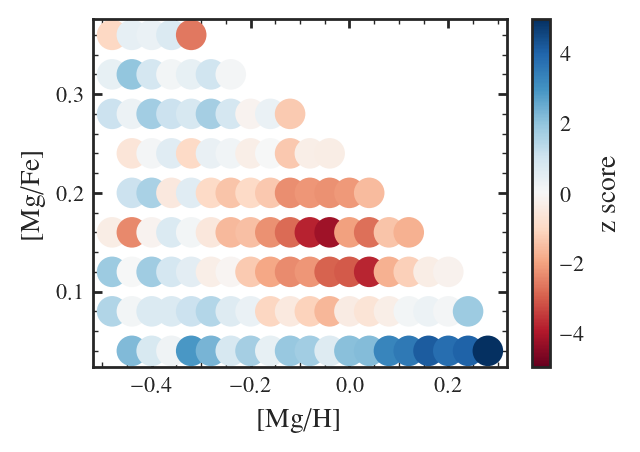

In [26]:
plot_all("fiducial")


length of samples =  48000
{'alpha': {'name': 'perturbations/fruity', 'prior': 'Normal', 'prior_args': [1.0, 1.0]}, 'y0_cc': {'name': 'perturbations/constant', 'prior': 'Normal', 'prior_args': [2.0, 1.0]}, 'zeta_cc': {'name': 'perturbations/linear', 'prior': 'Normal', 'prior_args': [0.0, 2.0], 'y0': 0.001}}
alpha      1.552545
y0_cc      1.742189
zeta_cc    0.431036
dtype: float64
chi2 reduced =  2.9241531734801085


/tmp/ipykernel_916725/1864777637.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_model = sum(alpha_mean[i] * afeh[label] for i, label in enumerate(labels))
/tmp/ipykernel_916725/1864777637.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_model = sum(alpha_mean[i] * afeh[label] for i, label in enumerate(labels))
/tmp/ipykernel_916725/1864777637.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_model = sum(alpha_mean

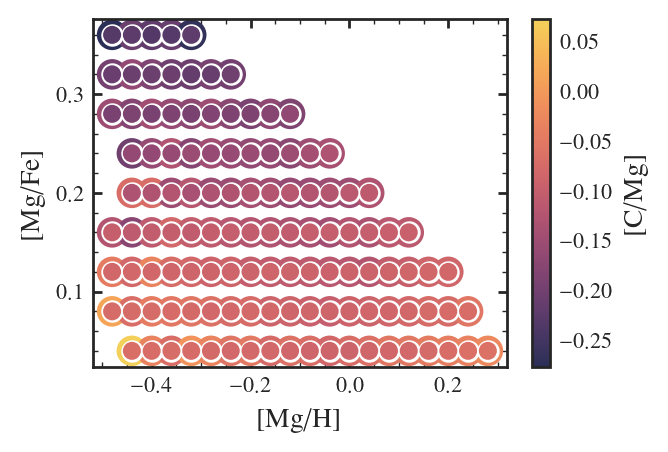

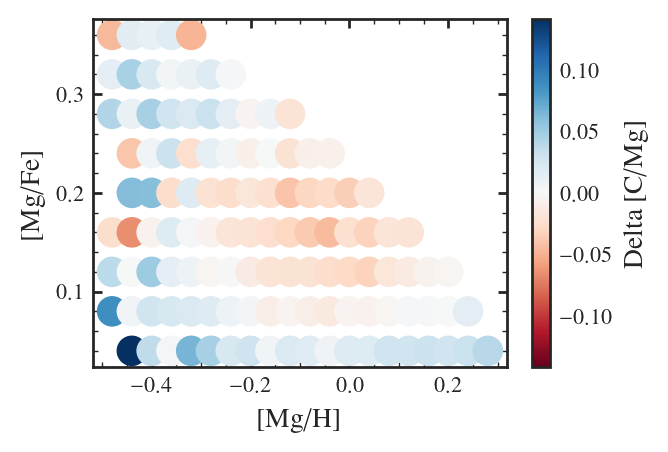

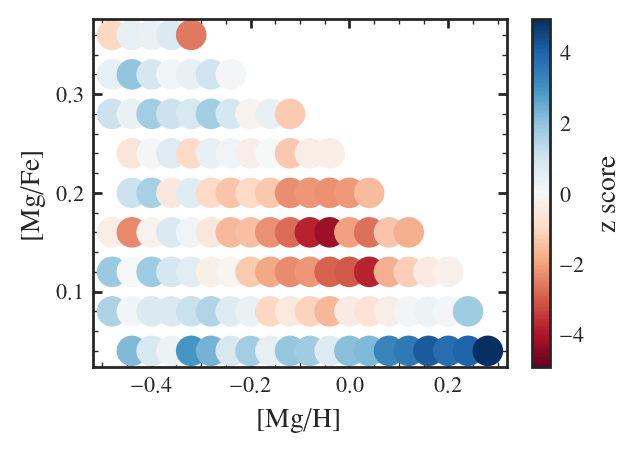

In [27]:
plot_all("fiducial_sigma")


length of samples =  48000
{'alpha': {'name': 'perturbations/fruity', 'prior': 'Normal', 'prior_args': [1.0, 1.0]}, 'y0_cc': {'name': 'perturbations/constant', 'prior': 'Normal', 'prior_args': [0.79, 0.01]}, 'zeta_cc': {'name': 'perturbations/linear', 'prior': 'Normal', 'prior_args': [0.0, 2.0], 'y0': 0.001}}
alpha      3.308493
y0_cc      0.865559
zeta_cc    0.824361
dtype: float64
chi2 reduced =  9.531138354790803


/tmp/ipykernel_916725/1864777637.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_model = sum(alpha_mean[i] * afeh[label] for i, label in enumerate(labels))
/tmp/ipykernel_916725/1864777637.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_model = sum(alpha_mean[i] * afeh[label] for i, label in enumerate(labels))
/tmp/ipykernel_916725/1864777637.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_model = sum(alpha_mean

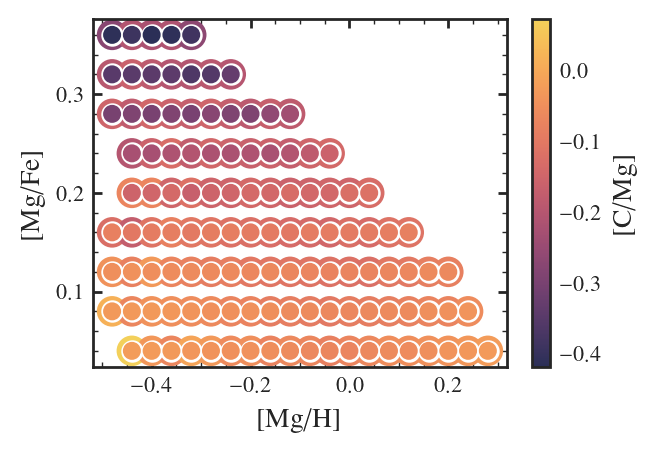

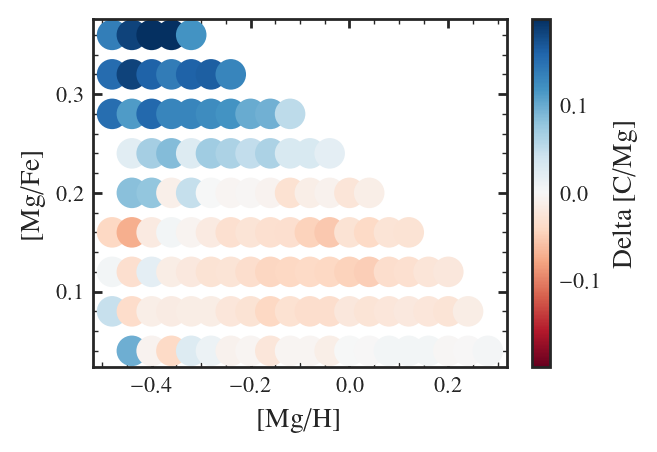

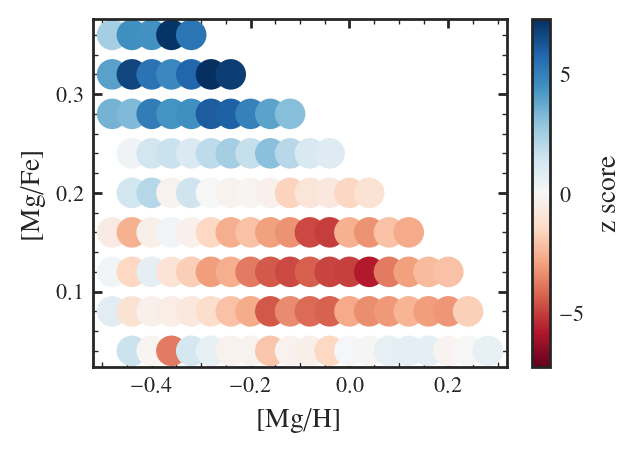

In [28]:
plot_all("fiducial_constrained")
